# Structures of missing data: Patterns that are interwoven

This example has one complete variable (M1), three variables with a monotone pattern (M2, M3 and M4) and two variables with a block pattern (B1 and B2). This also produces interwoven disjoint and monotone patterns.

The example also shows how to customise the colour and shape of nodes in the explanation graph, the colour of node text and modify the graph layout.

# Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from vizdataquality import plot as vdqp
from vizdataquality import missing_data_functions as mdf, missing_data_plots as mdp, missing_data_utils as mdu
from vizdataquality import explanation_graph as eg

## Create the dataframe

In [2]:
num_rows = 1000
num_missing_values = [0, int(num_rows*5/10), int(num_rows*8/10), num_rows]
value = 'x'
data = {}

# Variables with a monotone pattern
for l1 in range(len(num_missing_values)):
    num = num_missing_values[l1]
    
    if num == 0:
        data['M' + str(l1)] = [value] * num_rows
    elif num == num_rows:
        data['M' + str(l1)] = [np.nan] * num
    else:
        data['M' + str(l1)] = [np.nan] * num + [value] * (num_rows - num)

# Variables with a block pattern
n1 = int(num_rows*7/10)
n2 = int(num_rows*1.5/10)
data['B1'] = [value] * n1 + [np.nan] * n2 + [value] * (num_rows - n1 - n2) 
data['B2'] = data['B1']

df = pd.DataFrame.from_dict(data)
# Number of records in the dataset
num_records = len(df)

## Compute the missingness data structures

The data structures (data types) are as follows:
- num_missing (Series): The number of missing values in each variable.
- intersection_id_to_columns (DataFrame): A row for each combination of missing/present variables, and a column for each variable (set to True if value is missing, or False if value is present in that combination).
- intersection_id_to_records (DataFrame): A row for each record. The index is an intersection ID (usually not unique) and the column contains a record ID (not in any particular order).
- intersection_cardinality (Series): Series that contains the count for each intersection (i.e., the number of records that are missing that combination of variables).

In [3]:
num_missing, intersection_id_to_columns, intersection_id_to_records = mdf.get_intersections_from_dataframe(df)
intersection_cardinality = mdf.get_intersection_cardinality(intersection_id_to_records)

## Plot overview of missingness in dataset as a whole

One variable is complete (M1), one is empty (M5), and the others are partially missing. Overall, 1000 values are missing from the empty variable (M5) and 1600 values are missing from the partially missing variables. A total of 3400 values are present.

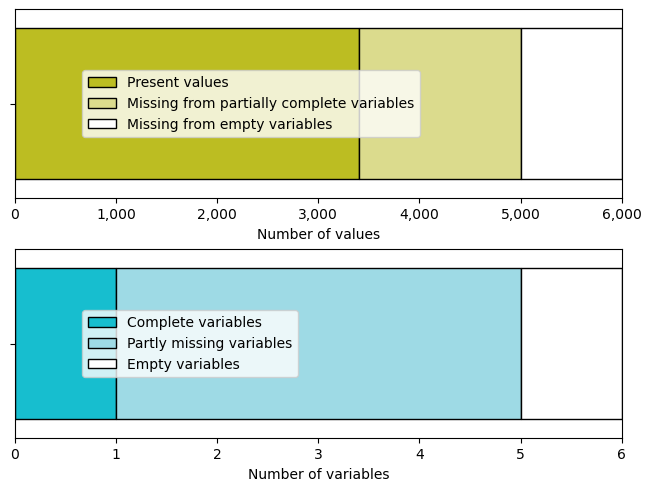

In [4]:
fig_kw = {'constrained_layout': True}
# Adjust the position and size of the legend
legend_kw = {'loc': 'center left', 'bbox_to_anchor': (0.1, 0.5)}
mdp.plot_summary_missingness(num_records, num_missing, num_rows=2, vert=False, fig_kw=fig_kw, legend_kw=legend_kw)

## Plot the number of missing values for each variable

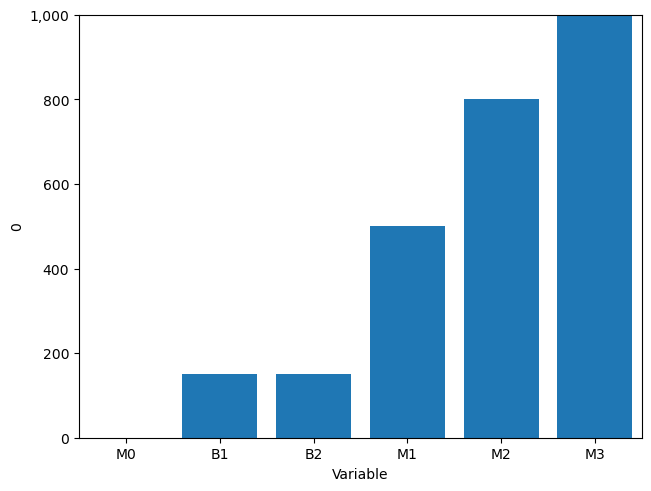

In [5]:
fig_kw = {'constrained_layout': True}
ax_kw = {'ylim': (0, num_records)}
vdqp.scalar_bar(num_missing.sort_values(), vert=True, fig_kw=fig_kw, ax_kw=ax_kw)

## Visualize the combinations of missing values

The bar chart above looks like a staircase, which suggests that there is a monotone pattern of missingness.

That is wrong, as the heatmap below shows. B1 and B2 are never missing when M1 is missing.

C:\Users\scsrar\Downloads\vizdataquality\vizdataquality\missing_data_plots.py:282: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vv = plotdata.iloc[i][j]


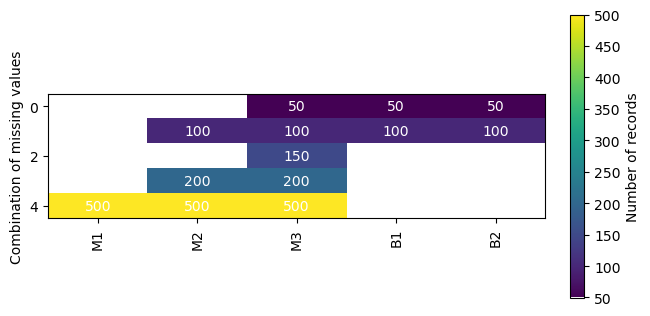

In [6]:
dftmp = mdf.get_intersection_heatmap_data(intersection_id_to_columns, intersection_cardinality)
# Sort the heatmap so the combinations are in ascending cardinality order
dftmp['_max'] = dftmp.max(axis=1)
df_heatmap = dftmp.sort_values(by='_max').drop(columns='_max')

fig_kw = {'constrained_layout': True}
ax_kw = {'ylabel': 'Combination of missing values'}
cbar_kw = {'label': 'Number of records', 'shrink': 0.6}

mdp.plot_intersection_heatmap(df_heatmap, transpose=False, xlabels_rotate=90, datalabels=True, fig_kw=fig_kw, ax_kw=ax_kw, cbar_kw=cbar_kw, aspect=0.25)

## Purities

### Calculate the pairwise purities for disjoint, block and monotone patterns

In [7]:
patterns = mdu.PATTERNS
threshold = 0.0
df_patterns = mdf.get_missiness_pattern(num_missing, intersection_id_to_columns, intersection_cardinality, patterns, threshold)

### Plot the pairwise purities

The line charts below indicate that all three types of pattern occur.

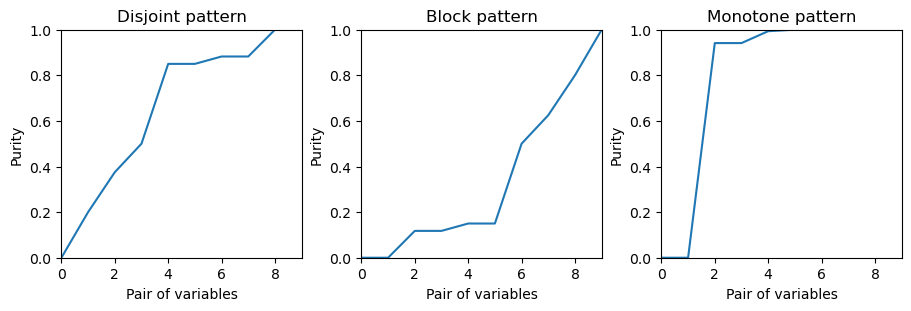

In [8]:
purities = [df_patterns[df_patterns['Pattern'] == i]['Purity'] for i in mdu.PATTERNS]
names = [i.capitalize() + ' pattern' for i in mdu.PATTERNS]

ax_kw = {'ylim': (0, 1), 'title': names}
fig_kw = {'size_inches': (9, 3), 'constrained_layout': True}
mdp.plot_purity_of_patterns(purities, perceptual_threshold=None, fig_kw=fig_kw, ax_kw=ax_kw)

### Indicate the most pure pattern for each pair of variables

The heatmap shows that the patterns are interwoven:
1. M1, M2 and M3 have a pure monotone pattern of missingness.
1. B1 and B2 have a pure block pattern of missingness (they are always missing together).
1. If B1 and B2 are missing then M1 is always present, and vice versa (a pure disjoint pattern).
1. If B1 and B2 are missing then M3 is always missing, and M3 is also missing in other records (a pure monotone pattern).
1. B1 and M2 are sometimes missing together and sometimes separately, and the same is true to B2 and M2. In fact it is 100 records together vs. 50 separately (see heatmap above), which is why the most pure pattern is monotone.

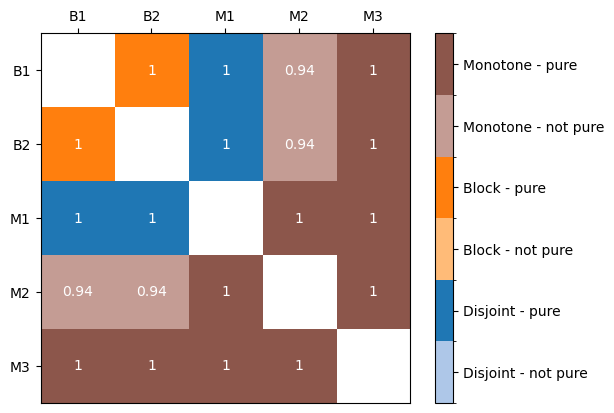

In [9]:
mdp.plot_purity_heatmap(df_patterns, datalabels=True)

## Explanation graph

### Initialise the graph

In [10]:
graph = eg.Explanation_Graph(intersection_id_to_columns, intersection_cardinality, criteria=eg.CHECK_COLUMNS)

### Add the nodes

In [11]:
cols = ['M1', 'M2', 'M3']
intersections = graph.get_intersections(cols)

ta_white = {'color': 'white'}
ba = {'facecolor': mdp.get_default_colours('purity heatmap monotone')[1]}

caption = 'M1, M2 and M3'
description = 'M1, M2 and M3 have a pure monotone pattern.'
graph.add_node(eg.Explanation_Node(cols, intersections, caption, description, text_attributes=ta_white, bbox_attributes=ba))

#### Plot a summary of the explanations so far

The graph summary shows the percentage of intersections (i.e., combinations of missing values), rows, columns and missing values that are completely, partly or not explained by the current graph.

At this stage of the investigation, two out of the six variables (B1, B2) and their missing values are not explained. The rows are either completely explained (only missing in M1, M2 and/or M3) or partly explained (also missing in B1 and B2). Three of the combinations of missing values are completely explained because they only involve M1, M2 and/or M3. The other two combinations are partly explained because they also involve B1 and B2.

C:\Users\scsrar\Downloads\vizdataquality\vizdataquality\explanation_graph.py:170: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return self._intersection_id_to_columns.copy().replace({-1: False, 0: np.nan, 1: True}).dropna(axis='columns', how='all').dropna(axis=0, how='all')


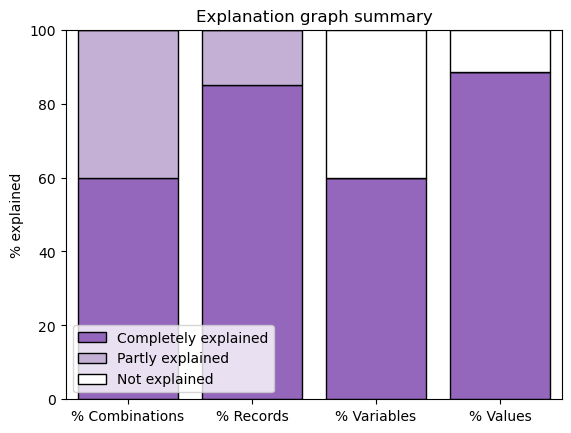

In [12]:
df_summ = graph.get_summary()
mdp.plot_explanation_graph_summary(df_summ)

#### Add other nodes

In [13]:
cols = ['B1', 'B2']
intersections = graph.get_intersections(cols, all_cols=True)

ba = {'facecolor': mdp.get_default_colours('purity heatmap block')[1]}

caption = 'B1 and B2'
description = 'B1 and B2 have a pure block pattern.'
graph.add_node(eg.Explanation_Node(cols, intersections, caption, description, bbox_attributes=ba))

In [14]:
cols = ['M1', 'B1', 'B2']
intersections = graph.get_intersections(cols)

ba = {'facecolor': mdp.get_default_colours('purity heatmap disjoint')[1], 'boxstyle': 'ellipse'}

caption = 'M1, B1 and B2'
description = 'M1/B1 and M1/B2 have pure disjoint patterns.'
graph.add_node(eg.Explanation_Node(cols, intersections, caption, description, bbox_attributes=ba))

In [15]:
cols = ['M2', 'B1', 'B2']
intersections = graph.get_intersections(cols)

ba = {'facecolor': mdp.get_default_colours('purity heatmap monotone')[0], 'boxstyle': 'ellipse'}

caption = 'M2, B1 and B2'
description = 'M2/B1 and M2/B2 have impure monotone patterns.'
graph.add_node(eg.Explanation_Node(cols, intersections, caption, description, bbox_attributes=ba))

In [16]:
cols = ['M3', 'B1', 'B2']
intersections = graph.get_intersections(cols)

ba = {'facecolor': mdp.get_default_colours('purity heatmap monotone')[1], 'boxstyle': 'ellipse'}

caption = 'M3, B1 and B2'
description = 'M3/B1 and M3/B2 have pure monotone patterns.'
graph.add_node(eg.Explanation_Node(cols, intersections, caption, description, text_attributes=ta_white, bbox_attributes=ba))

## Summary of explanations

C:\Users\scsrar\Downloads\vizdataquality\vizdataquality\explanation_graph.py:170: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return self._intersection_id_to_columns.copy().replace({-1: False, 0: np.nan, 1: True}).dropna(axis='columns', how='all').dropna(axis=0, how='all')


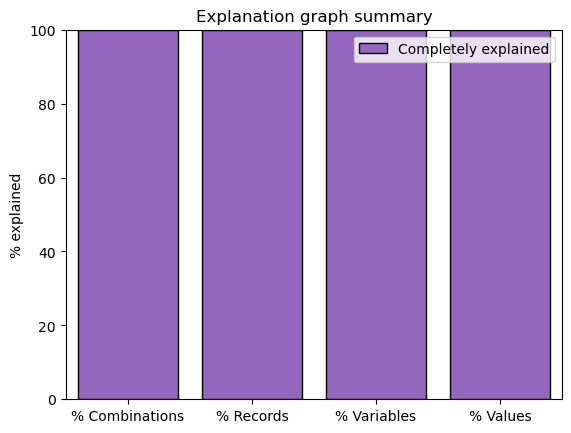

In [17]:
df_summ = graph.get_summary()
mdp.plot_explanation_graph_summary(df_summ)

# Visualize the complete explanation graph

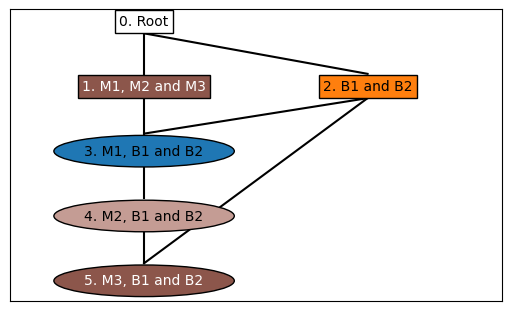

In [18]:
fig_kw = {'size_inches': (5, 3), 'constrained_layout': True}
mdp.plot_explanation_graph_diagram(graph, fig_kw=fig_kw)

## Customise the graph layout

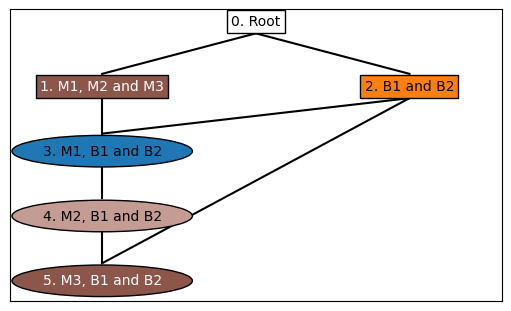

In [19]:
npos = {0: {'x': 1}, 2: {'x': 2}}
mdp.plot_explanation_graph_diagram(graph, node_positions=npos, fig_kw=fig_kw)